# Stress Level Prediction

### Module: Stress Level Prediction Based on Digital Habits and Mental Health

In [3]:
## -- Import necessary libraries --

import numpy as np
import pandas as pd
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message="X does not have valid feature names, but LGBMRegressor was fitted with feature names")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
## -- Load the dataset --

df = pd.read_csv(r"C:\Users\mahes\Downloads\digital_habits_vs_mental_health.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   screen_time_hours            100000 non-null  float64
 1   social_media_platforms_used  100000 non-null  int64  
 2   hours_on_TikTok              100000 non-null  float64
 3   sleep_hours                  100000 non-null  float64
 4   stress_level                 100000 non-null  int64  
 5   mood_score                   100000 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 4.6 MB


In [6]:
# --- DEFINE FUNCTION FOR DETAILED NUMERICAL SUMMARY ---

def num_summary(dataframe, numerical_col, plot=False): 
    import matplotlib.pyplot as plt
    
    quantiles = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    
    if plot:
        dataframe[numerical_col].hist(bins=55)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()
    
    print("#####################################\n\n\n")


count   100000.000
mean         6.004
std          1.987
min          1.000
10%          3.400
20%          4.300
30%          4.900
40%          5.500
50%          6.000
60%          6.500
70%          7.000
80%          7.700
90%          8.600
95%          9.300
99%         10.700
max         12.000
Name: screen_time_hours, dtype: float64


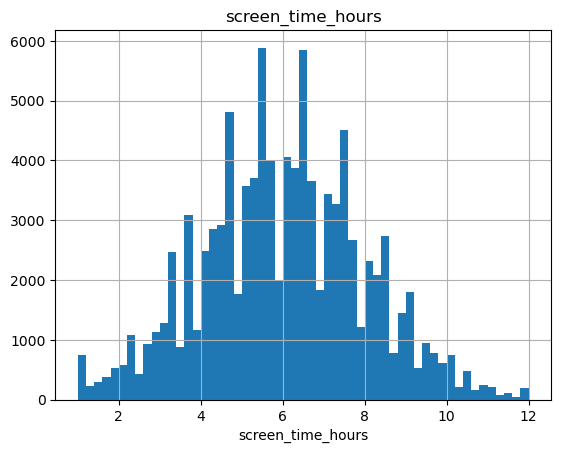

#####################################



count   100000.000
mean         2.998
std          1.414
min          1.000
10%          1.000
20%          1.000
30%          2.000
40%          2.000
50%          3.000
60%          3.000
70%          4.000
80%          4.000
90%          5.000
95%          5.000
99%          5.000
max          5.000
Name: social_media_platforms_used, dtype: float64


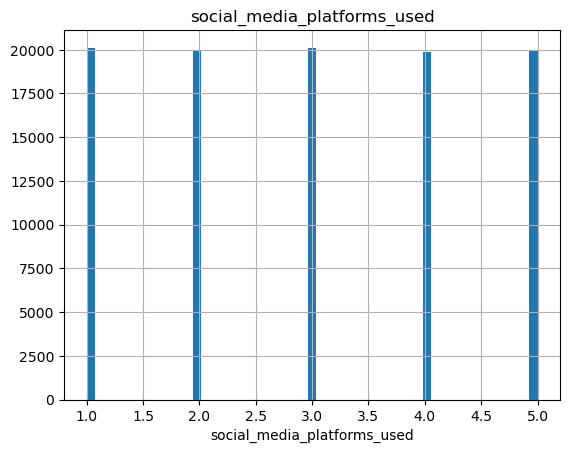

#####################################



count   100000.000
mean         2.401
std          1.079
min          0.200
10%          1.100
20%          1.500
30%          1.700
40%          2.000
50%          2.300
60%          2.500
70%          2.900
80%          3.300
90%          3.900
95%          4.400
99%          5.300
max          7.200
Name: hours_on_TikTok, dtype: float64


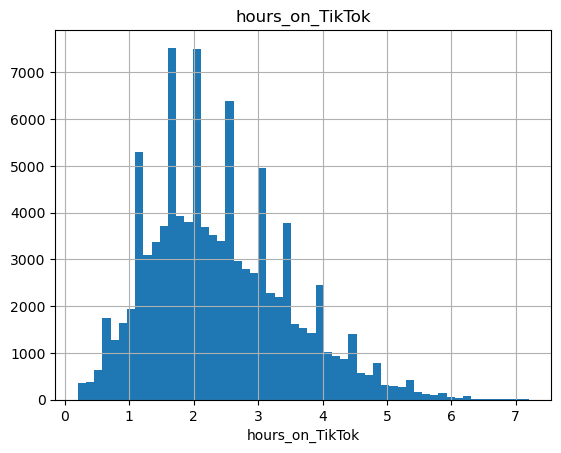

#####################################



count   100000.000
mean         6.988
std          1.466
min          3.000
10%          5.100
20%          5.700
30%          6.200
40%          6.600
50%          7.000
60%          7.400
70%          7.800
80%          8.300
90%          8.900
95%          9.500
99%         10.000
max         10.000
Name: sleep_hours, dtype: float64


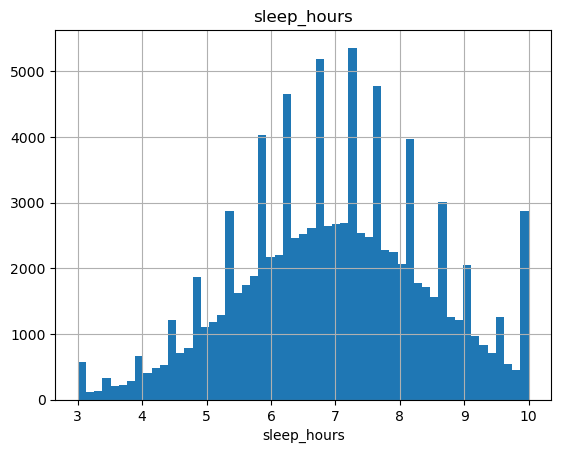

#####################################



count   100000.000
mean         6.180
std          2.045
min          1.000
10%          4.000
20%          4.000
30%          5.000
40%          6.000
50%          6.000
60%          7.000
70%          7.000
80%          8.000
90%          9.000
95%         10.000
99%         10.000
max         10.000
Name: stress_level, dtype: float64


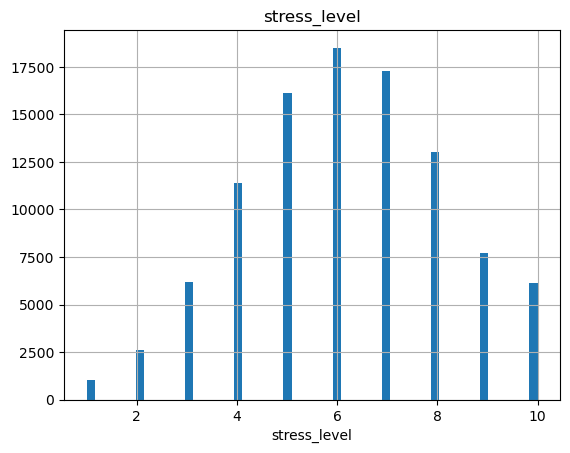

#####################################



count   100000.000
mean         9.061
std          1.278
min          2.000
10%          7.000
20%          8.000
30%          9.000
40%          9.000
50%         10.000
60%         10.000
70%         10.000
80%         10.000
90%         10.000
95%         10.000
99%         10.000
max         10.000
Name: mood_score, dtype: float64


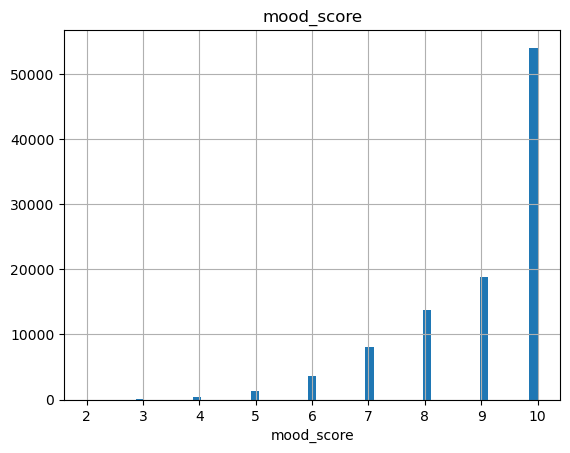

#####################################





In [7]:
# Iterate through each of the numerical columns.
for col in df.columns:
    # Call the num_summary function for each column with plot=True.
    # This will display both the detailed statistical summary and a histogram,
    # allowing for a final visual inspection of the feature distributions before modeling.
    num_summary(df, col, True)

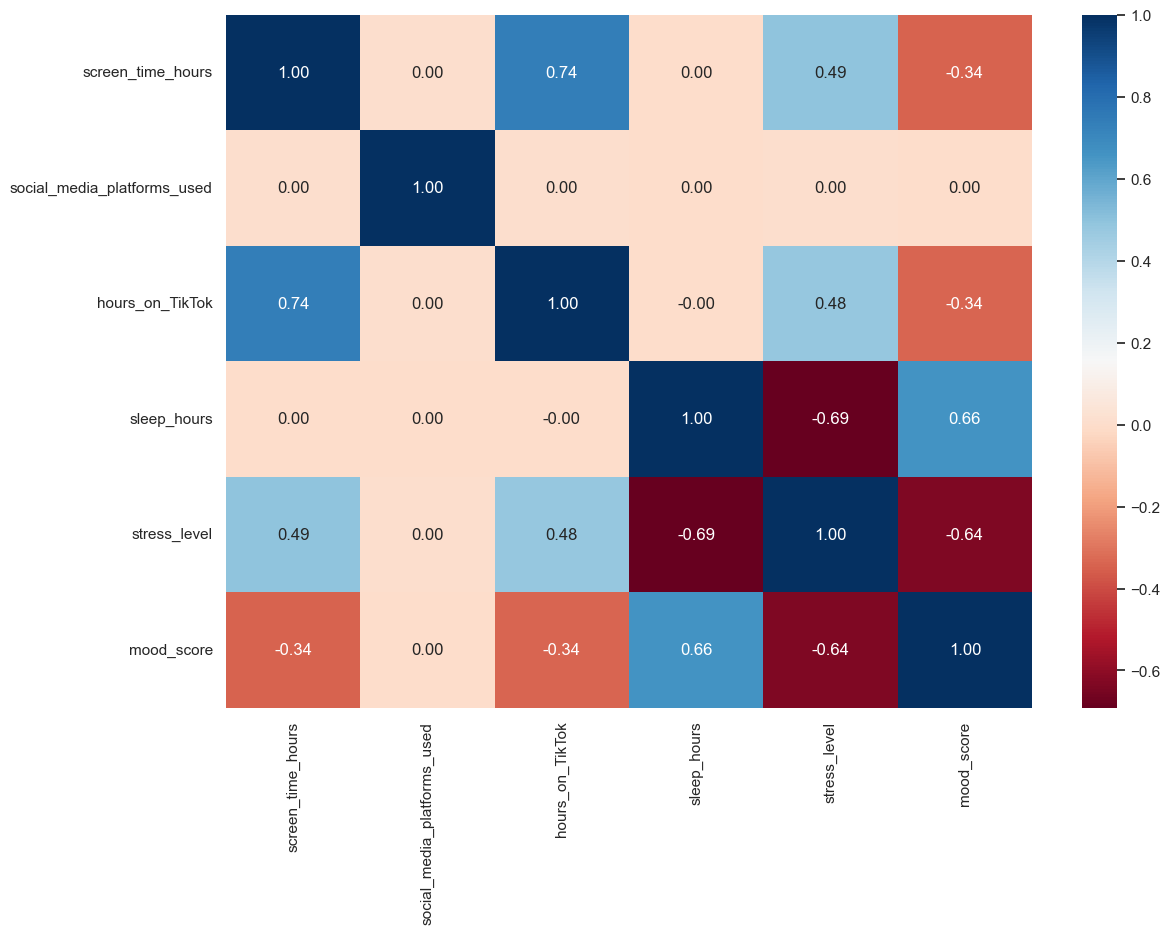

[]

In [8]:
# --- ANALYZE FEATURE CORRELATION ---

def high_correlated_cols(dataframe, plot=False, corr_th=0.85):
   # Calculate the pairwise correlation matrix for the dataframe
    corr = dataframe.corr()

    # Get the absolute values of the correlations to handle both positive and negative high correlations
    cor_matrix = corr.abs()

    # Create a boolean mask for the upper triangle of the matrix to avoid duplicate pairs (corr(A,B) == corr(B,A))
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))

    # Identify columns that have a correlation value greater than the threshold in the upper triangle
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]

    # If plotting is requested by the user, display a heatmap
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (13, 9)})

        # Generate the heatmap with annotations for clarity
        # annot=True: displays the correlation values on the cells.
        # fmt='.2f': formats the numbers to two decimal places.
        sns.heatmap(corr, cmap="RdBu", annot=True, fmt='.2f')
        plt.show()

    return drop_list

# Call the function on the numerical columns of our dataframe to see the correlation heatmap
# and get a list of features with a correlation higher than 0.85 (if any).
high_correlated_cols(df[df.columns], plot=True)
    

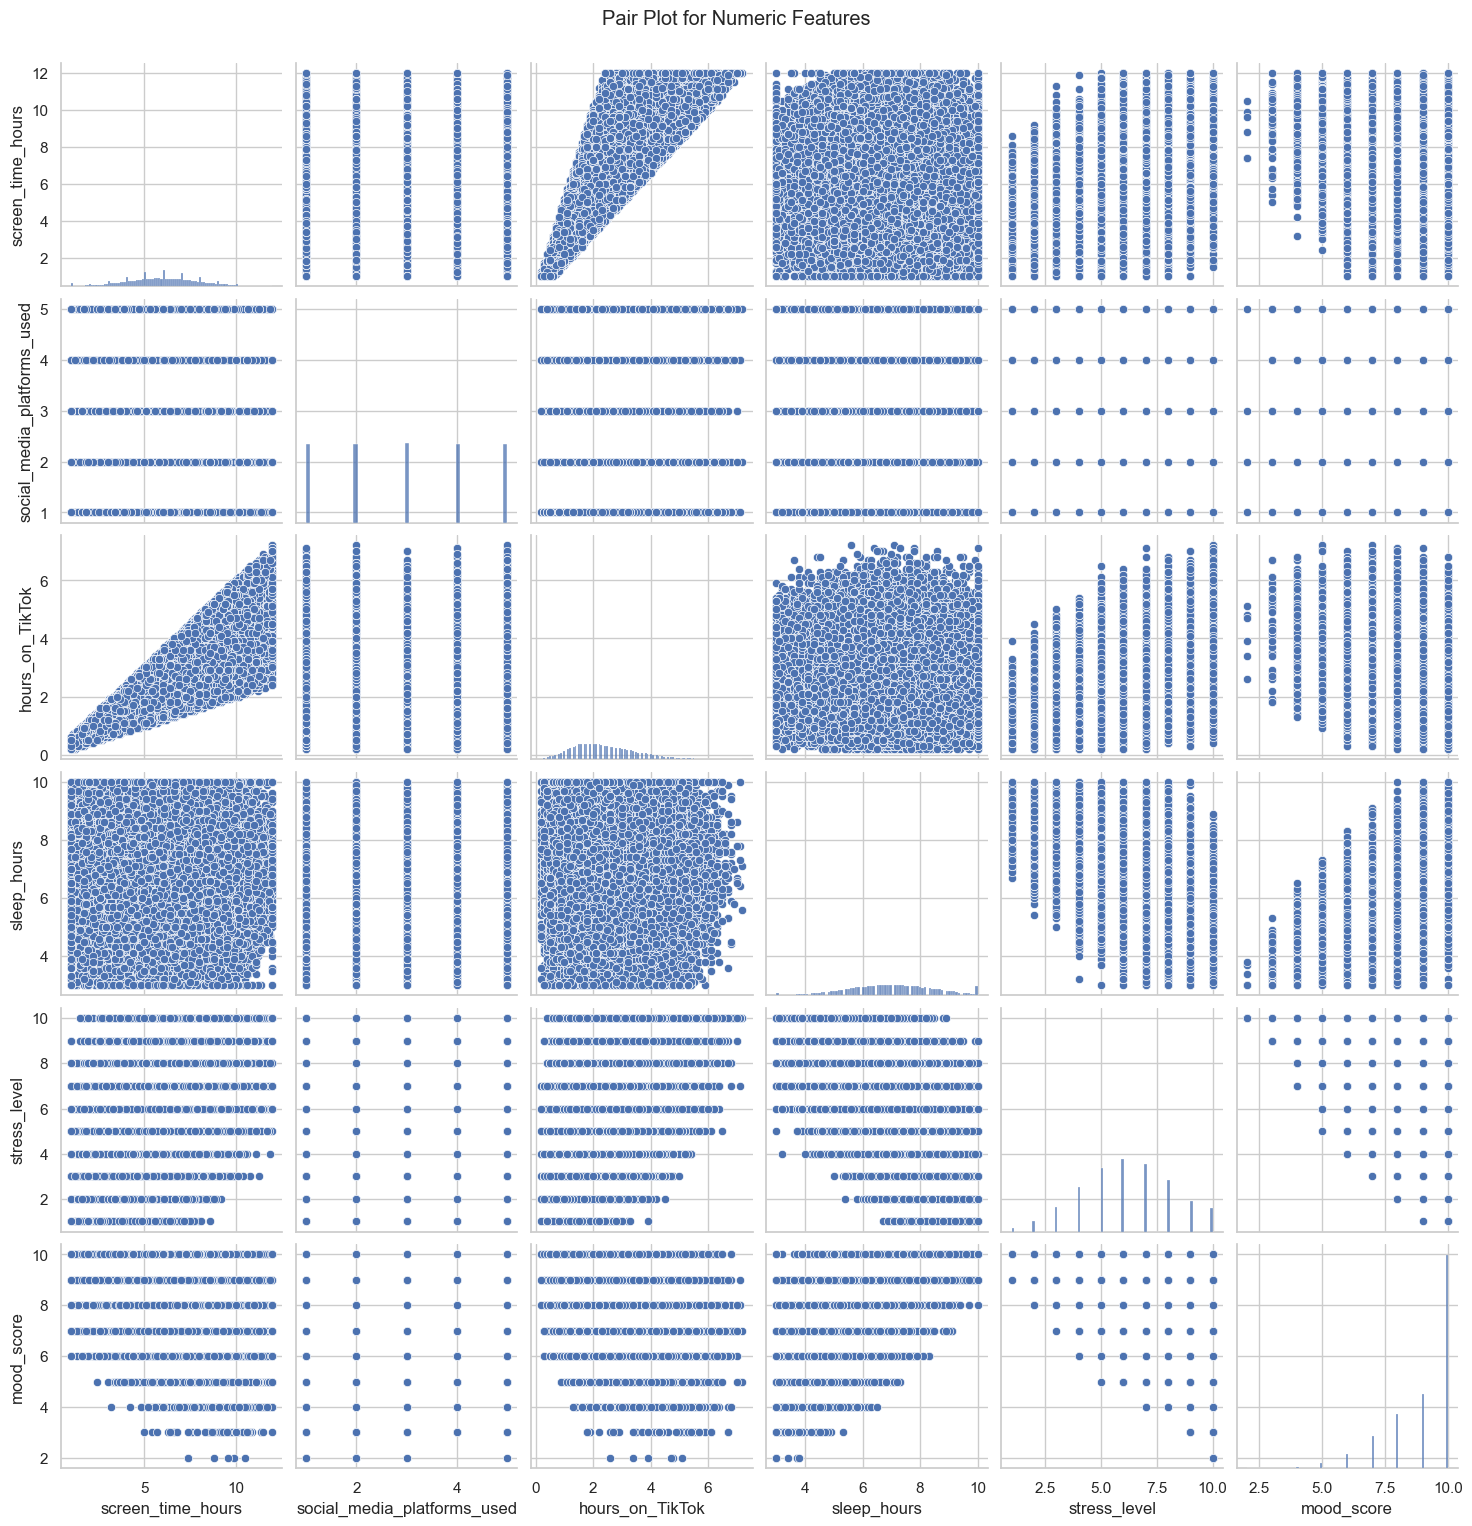

In [17]:
def create_pair_plot(dataframe: pd.DataFrame):
    """
    Generates and displays a pair plot for the numerical features of a dataframe.

    # This function creates a grid of plots where:
    # 1. The diagonal axes show the distribution of each individual feature using a histogram.
    #    This helps in understanding the spread and shape (e.g., symmetric, skewed) of each variable.
    # 2. The off-diagonal axes show the relationship between each pair of features using a scatter plot.
    #    This is useful for visually identifying correlations, trends, and potential patterns between variables.
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    sns.set_theme(style="whitegrid")
    sns.pairplot(dataframe)
    plt.suptitle('Pair Plot for Numeric Features', y=1.02) # Adjust title position
    plt.show()

create_pair_plot(df)

In [21]:
# --- DEFINE OUTLIER HANDLING FUNCTIONS (REFINED) ---

def outlier_thresholds(dataframe, variable, low_quantile=0.25, up_quantile=0.75):
    """
    Calculates the lower and upper outlier thresholds for a given variable using the standard Interquartile Range (IQR) method.
    The thresholds are calculated as Q1 - 1.5*IQR and Q3 + 1.5*IQR.

    Args:
        dataframe (pd.DataFrame): The dataframe containing the data.
        variable (str): The name of the column (variable) to calculate thresholds for.
        low_quantile (float): The lower quantile (default is 0.25 for Q1).
        up_quantile (float): The upper quantile (default is 0.75 for Q3).

    Returns:
        tuple: A tuple containing the calculated lower and upper limits for outliers.
    """
    # Calculate the specified lower (Q1) and upper (Q3) quantile values
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)

    # Calculate the interquantile range (IQR)
    interquantile_range = quantile_three - quantile_one

    # Calculate the upper and lower outlier limits
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range

    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    """
    Checks if a given column contains any outliers by using the thresholds from the outlier_thresholds() function.

    Args:
        dataframe (pd.DataFrame): The dataframe to check.
        col_name (str): The name of the column to check for outliers.

    Returns:
        bool: Returns True if outliers are present, otherwise returns False.
    """
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    """
    Replaces outliers in a specified column with the calculated outlier thresholds (capping/winsorizing).
    The operation is performed in-place on the provided dataframe.

    Args:
        dataframe (pd.DataFrame): The dataframe to be modified.
        variable (str): The name of the column in which to cap the outliers.
    """
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit



In [26]:
# --- EXECUTE OUTLIER ANALYSIS ---

# Define the list of numerical columns, excluding our target variable 'stress_level' and its proxy 'mood_score'.
# We generally do not perform outlier capping on the target variable.
num_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] and col not in ["stress_level", "mood_score"]]

# Check each numerical column for outliers
outlier_summary = {col: check_outlier(df, col) for col in num_cols}

# Get the list of columns that contain outliers
columns_with_outliers = [col for col, has_outlier in outlier_summary.items() if has_outlier]

print("Columns with potential outliers (using IQR method):")
columns_with_outliers

Columns with potential outliers (using IQR method):


['screen_time_hours', 'hours_on_TikTok']

In [28]:
# Apply the outlier capping to the identified columns
for col in columns_with_outliers:
    replace_with_thresholds(df, col)
    print(f"Outliers in '{col}' have been capped.")

Outliers in 'screen_time_hours' have been capped.
Outliers in 'hours_on_TikTok' have been capped.


In [31]:
# --- FEATURE ENGINEERING ---

# 1. Ratio of TikTok time to total screen time
# This feature calculates what proportion of total screen time is spent specifically on TikTok.
# A high ratio might indicate a more passive or potentially addictive form of screen use.
df['NEW_tiktok_to_screen_ratio'] = df['hours_on_TikTok'] / df['screen_time_hours']
df['NEW_tiktok_to_screen_ratio'].fillna(0, inplace=True) # Handle cases where screen_time_hours might be 0

# 2. Ratio of screen time to sleep hours
# This feature directly compares a potentially negative habit (screen time) with a positive one (sleep).
# A higher value suggests a lifestyle where screen time dominates over sleep, which could be a strong predictor of stress.
df['NEW_screen_to_sleep_ratio'] = df['screen_time_hours'] / df['sleep_hours']

# 3. Non-TikTok Screen Time
# This calculates the amount of screen time spent on activities other than TikTok.
# It helps to isolate the impact of general screen usage versus the specific influence of TikTok.
df['NEW_non_tiktok_screen_time'] = df['screen_time_hours'] - df['hours_on_TikTok']
# Ensure the value is not negative, which could happen due to data noise.
df['NEW_non_tiktok_screen_time'] = np.maximum(0, df['NEW_non_tiktok_screen_time'])

# 4. Categorical Sleep Quality
# This converts the continuous 'sleep_hours' variable into meaningful categories.
# It helps the model interpret sleep quality in segments (Poor, Average, Good) rather than as a continuous value.
bins = [0, 6, 8, np.inf]
labels = ['Poor_Sleep', 'Average_Sleep', 'Good_Sleep']
df['NEW_sleep_category'] = pd.cut(df['sleep_hours'], bins=bins, labels=labels, right=False)

# 5. Screen Time Level
# This categorizes users into 'Low', 'Moderate', and 'High' screen time users.
# This can help linear models capture non-linear relationships and segment users into behavioral groups.
bins = [0, 4, 8, np.inf]
labels = ['Low_ScreenTime', 'Moderate_ScreenTime', 'High_ScreenTime']
df['NEW_screen_time_category'] = pd.cut(df['screen_time_hours'], bins=bins, labels=labels, right=False)

# 6. Interaction between platforms and screen time
# This feature tests the hypothesis that using many platforms for a long time has a combined, stronger effect on stress.
df['NEW_platform_x_screentime'] = df['social_media_platforms_used'] * df['screen_time_hours']

print("New features created successfully. Displaying the first 5 rows with new columns:")
print(df.head())

New features created successfully. Displaying the first 5 rows with new columns:
   screen_time_hours  social_media_platforms_used  hours_on_TikTok  \
0             10.300                            2            5.300   
1              6.500                            5            3.500   
2              9.100                            4            2.800   
3              6.500                            3            2.500   
4              2.100                            3            1.200   

   sleep_hours  stress_level  mood_score  NEW_tiktok_to_screen_ratio  \
0        4.400            10           5                       0.515   
1        6.200             8           8                       0.538   
2        6.600             7           8                       0.308   
3        6.500             7           9                       0.385   
4        7.800             2          10                       0.571   

   NEW_screen_to_sleep_ratio  NEW_non_tiktok_screen_time NEW_slee

In [34]:
from sklearn.preprocessing import OrdinalEncoder

# Define the categorical columns that we created earlier.
cat_cols = ['NEW_sleep_category', 'NEW_screen_time_category']

# Define the specific order for each categorical variable.
# This is crucial for OrdinalEncoder to work correctly.
sleep_order = ['Poor_Sleep', 'Average_Sleep', 'Good_Sleep']
screentime_order = ['Low_ScreenTime', 'Moderate_ScreenTime', 'High_ScreenTime']

# Create an instance of the encoder with the specified category orders.
ordinal_encoder = OrdinalEncoder(categories=[sleep_order, screentime_order])

# Apply the encoder to the categorical columns of the dataframe.
# The result will be new columns with numerical representations.
df[cat_cols] = ordinal_encoder.fit_transform(df[cat_cols])

print("Ordinal encoding applied successfully.")
print(df[['NEW_sleep_category', 'NEW_screen_time_category']].head())

# You can check the mapping that the encoder learned.
print("\nEncoder Mappings:")
print(ordinal_encoder.categories_)

Ordinal encoding applied successfully.
   NEW_sleep_category  NEW_screen_time_category
0               0.000                     2.000
1               1.000                     1.000
2               1.000                     2.000
3               1.000                     1.000
4               1.000                     0.000

Encoder Mappings:
[array(['Poor_Sleep', 'Average_Sleep', 'Good_Sleep'], dtype=object), array(['Low_ScreenTime', 'Moderate_ScreenTime', 'High_ScreenTime'],
      dtype=object)]


## A Note on Dropping the mood_score Variable

Before proceeding with the model, it's crucial to reiterate why the mood_score column is excluded from our features. This is a deliberate methodological decision to prevent target leakage.

stress_level (our target) and mood_score both describe a person's current mental state ("what" they are feeling). Our project's goal, however, is to predict this state using behavioral data like sleep_hours and screen_time_hours ("why" they might be feeling that way).

Including mood_score would mean we are using one state variable to predict another, which would create a misleadingly accurate but practically useless model. The model would fail in a real-world scenario where we only have the behavioral data ("why") and not the self-reported mood_score. By removing it, we ensure our model learns the meaningful relationship between digital habits and stress.

In [41]:
!pip install lightgbm


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   --------------------- ------------------ 0.8/1.5 MB 2.4 MB/s eta 0:00:01
   ---------------------------- ----------- 1.0/1.5 MB 2.3 MB/s eta 0:00:01
   ------------------------------------ --- 1.3/1.5 MB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 1.7 MB/s eta 0:00:00


In [45]:
# --- PREPARE DATA FOR MODELING ---


import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define the target vector 'y'
y = df['stress_level']

# Define the feature matrix 'X'.
# We drop the target variable 'stress_level' and its proxy 'mood_score' to prevent target leakage.
X = df.drop(['stress_level', 'mood_score'], axis=1)

# We split the data to train the model on one subset and evaluate its performance on a separate, unseen subset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print("Data splitting is complete:")
print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")
print("-" * 40)

Data splitting is complete:
Training Features Shape: (80000, 10)
Testing Features Shape: (20000, 10)
----------------------------------------


In [49]:
# --- Initialize and Train the LightGBM Model ---

# Initialize the LGBM Regressor with the verbose parameter set to -1 to suppress info logs.
lgbm_model = lgb.LGBMRegressor(random_state=42, verbose=-1)

# Fit the model to the training data.
lgbm_model.fit(X_train, y_train)

# Make predictions on the unseen test data.
y_pred = lgbm_model.predict(X_test)

# Calculate performance metrics.
# RMSE (Root Mean Squared Error) shows the average prediction error in the same unit as the target. Lower is better.
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# R-squared (R²) indicates the proportion of the variance in the target that is predictable from the features. Higher is better.
r2 = r2_score(y_test, y_pred)

print("Model Performance Metrics:")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print("-" * 40)

Model Performance Metrics:
RMSE (Root Mean Squared Error): 1.0243
R-squared (R²): 0.7502
----------------------------------------


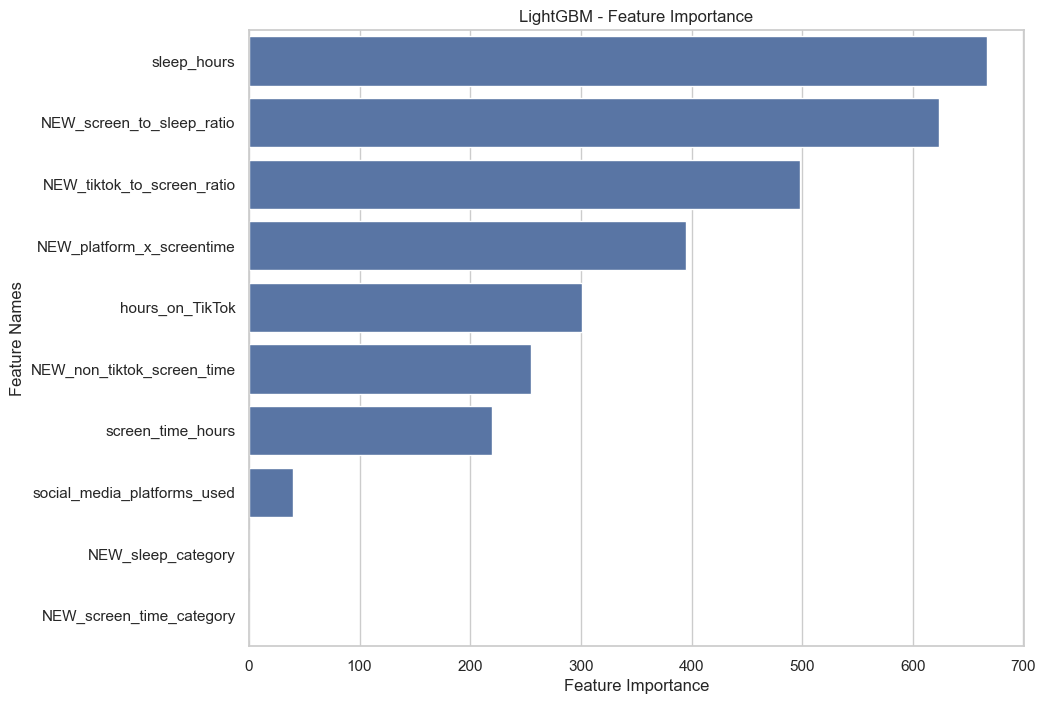

In [51]:
def plot_feature_importance(importance, names, model_type):

    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # This function creates a plot to show which features the model found most predictive.
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    plt.figure(figsize=(10, 8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + ' - Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.show()

plot_feature_importance(lgbm_model.feature_importances_, X.columns, 'LightGBM')


In [54]:
# --- HYPERPARAMETER TUNING FOR LIGHTGBM ---
'''
import optuna
import logging

# Add this line to suppress INFO-level logging from Optuna.
# This will hide the details of each trial finishing.
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Veri setimiz zaten X ve y olarak hazır. Tekrar ayıralım.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

def objective(trial):
    """
    This function defines one trial of the optimization process.
    Optuna will call this function many times with different hyperparameter values.
    """
    # 1. Define the search space for the hyperparameters.
    # Optuna will suggest a value for each hyperparameter in each trial.
    params = {
        'objective': 'regression_l1', # MAE
        'metric': 'rmse', # Root Mean Squared Error
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'random_state': 42,
        'verbose': -1 # Suppress verbose output
    }

    # 2. Create and train the model with the suggested parameters.
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)

    # 3. Evaluate the model and return the score to be optimized.
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    # Optuna will try to minimize this return value.
    return rmse

# 1. Create a study object. We want to 'minimize' the 'objective' function's return value (RMSE).
study = optuna.create_study(direction='minimize')

# 2. Start the optimization process. n_trials is the number of different hyperparameter combinations to test.
study.optimize(objective, n_trials=50) # You can increase n_trials for a more thorough search, e.g., 100.

# 3. Print the results of the best trial.
print("Optimization finished.")
print("Best trial:")
best_trial = study.best_trial

print(f"  Value (RMSE): {best_trial.value:.4f}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")
'''

'\nimport optuna\nimport logging\n\n# Add this line to suppress INFO-level logging from Optuna.\n# This will hide the details of each trial finishing.\noptuna.logging.set_verbosity(optuna.logging.WARNING)\n\n# Veri setimiz zaten X ve y olarak hazır. Tekrar ayıralım.\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)\n\ndef objective(trial):\n    """\n    This function defines one trial of the optimization process.\n    Optuna will call this function many times with different hyperparameter values.\n    """\n    # 1. Define the search space for the hyperparameters.\n    # Optuna will suggest a value for each hyperparameter in each trial.\n    params = {\n        \'objective\': \'regression_l1\', # MAE\n        \'metric\': \'rmse\', # Root Mean Squared Error\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 200, 2000),\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.01, 0.3),\n        \'num_leaves\': trial.suggest

In [57]:
# --- FINAL MODEL TRAINING AND EVALUATION ---

import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# 1. Use the best hyperparameters found by the Optuna CV study
best_params = {
    'n_estimators': 881,
    'learning_rate': 0.026444359949647153,
    'num_leaves': 265,
    'max_depth': 4,
    'min_child_samples': 62,
    'feature_fraction': 0.8257002377194269,
    'bagging_fraction': 0.5270824866417714,
    'bagging_freq': 5,
    'lambda_l1': 0.00048030294661386655,
    'lambda_l2': 0.0001749676977427815,
    'random_state': 42,
    'verbose': -1,
    'objective': 'regression_l1',
    'metric': 'rmse'
}

# 2. Initialize the final model with the best parameters
final_model = lgb.LGBMRegressor(**best_params)

# 3. Train the final model on the ENTIRE training dataset
# This allows the model to learn from all available training data.
final_model.fit(X_train, y_train)

# 4. Evaluate the final model on the unseen test set
final_preds = final_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, final_preds))
final_r2 = r2_score(y_test, final_preds)

print("\n--- Final Tuned Model Performance on Test Set ---")
print(f"Final RMSE: {final_rmse:.4f}")
print(f"Final R-squared (R²): {final_r2:.4f}")


--- Final Tuned Model Performance on Test Set ---
Final RMSE: 1.0255
Final R-squared (R²): 0.7496


In [60]:
# Create a new column in the original dataframe to store our predictions.
# Predictions only exist for the test set, so train set rows will be NaN.
df['predicted_stress'] = pd.Series(final_preds, index=y_test.index)

# Create a new dataframe to display only the test set results for clarity.
# We select the actual 'stress_level' and our new 'predicted_stress' columns.
results_comparison = df.loc[y_test.index, ['stress_level', 'predicted_stress']]
results_comparison_sorted = results_comparison.sort_index(ascending=True)

# Display the first 15 rows of the comparison.
results_comparison_sorted.head(15)

,stress_level,predicted_stress
8,5,6.034
23,4,4.084
39,6,7.058
53,5,5.603
70,6,4.983
75,7,6.842
87,7,6.874
88,5,4.160
95,3,4.102
97,4,3.325
